In [1]:
from xclib.data import data_utils
import numpy as np
import time
import pickle
import copy

In [2]:
#Change this later. Make the path as command line argument
X_train = data_utils.read_sparse_file('ass3_parta_data/train_x.txt', force_header=True)
train_class = np.genfromtxt('ass3_parta_data/train_y.txt').reshape(-1, 1)

X_valid = data_utils.read_sparse_file('ass3_parta_data/valid_x.txt', force_header=True)
valid_class = np.genfromtxt('ass3_parta_data/valid_y.txt').reshape(-1, 1)

X_test = data_utils.read_sparse_file('ass3_parta_data/test_x.txt', force_header=True)
test_class = np.genfromtxt('ass3_parta_data/test_y.txt').reshape(-1, 1)

/home/ayushi/.local/lib/python3.6/site-packages/xclib-0.96-py3.6-linux-x86_64.egg/xclib/data/data_utils.py:173: UserWarning: Header mis-match from inferred shape!
  warnings.warn("Header mis-match from inferred shape!")


In [3]:
# Loading the number of samples and attributes
f = open('ass3_parta_data/train_x.txt') 
m,n = f.readlines()[0].rstrip("\n").split(" ")
m,n = int(m),int(n)
f.close()

In [4]:
#Determine the number of unique classes 
classes = np.unique(train_class)

In [5]:
attributes = np.array(range(X_train.A.shape[1]))

### Entropy H(Y) is calculated assuming Y only has two classes - 0 and 1

###### So we use log_2 and use pos and neg_num

In [6]:
def calc_entropyY(train_data, train_class):
    pos_num = train_data[np.where(train_class == 1)[0]].shape[0]
    neg_num = train_data[np.where(train_class == 0)[0]].shape[0]
    
    if (pos_num == 0) or (neg_num == 0):
        entr = 0 #in the limit
    else:
        entr = (pos_num/(pos_num+neg_num))*np.log2((pos_num+neg_num)/pos_num) + (neg_num/(pos_num+neg_num))*np.log2((pos_num+neg_num)/neg_num)
        
    return entr

In [7]:
#Entropy of Raw data
start = time.time()
print(calc_entropyY(X_train.A, train_class))
print("time = ", time.time()-start)

0.997775157550985
time =  0.0878000259399414


#### Reduction in Error is given by H(Y|X) by using value to split at the node
H(Y|X) 

       = H(Y|X=x)P(X=x)  -- find the two splits 

       = H(Y=y|X=x)P(X=x) -- find the entropy of both the splits. 

       = calc_entropy(split1, train_class_split1).P(X=x)
    

In [8]:
def calc_red_error(train_data, split, split_class, train_class):
    #print("In reduction of Error Module")
    #print(train_data.shape[0])
    error = 0
    for i in range(len(split)):
    #    print("Split shape = ", split[i].shape)
        error += (split[i].shape[0]/train_data.shape[0])*calc_entropyY(split[i], split_class[i])
    #print("Reduction in error = ", error)
    return error


In [9]:
def find_best_attr(train_data, train_class):
    #max_mutual_info = 0;   This doesnt work for the cases when mutual info becomes negative. 
    max_mutual_info = float("-inf");
    median = (np.median(train_data, axis=0))        
    #print(median)
    for i in range(len(attributes)):
        split = []
        split_class = []
        split.append(train_data[np.where(train_data[:,i] <= median[i])])
        split.append(train_data[np.where(train_data[:,i] > median[i])])
        split_class.append(train_class[np.where(train_data[:,i] <= median[i])])
        split_class.append(train_class[np.where(train_data[:,i] > median[i])])
        mutual_info = calc_entropyY(train_data, train_class) - calc_red_error(train_data, split, split_class, train_class)
        #print(mutual_info)
        if max_mutual_info < mutual_info:
            max_mutual_info = mutual_info
            best_attr = attributes[i]
            thres = median[i]
    return max_mutual_info, best_attr, thres

In [10]:
start = time.time()
print(find_best_attr(X_train.A, train_class))
print(time.time()-start)

(0.0793751756882577, 217, 0.0)
30.544697284698486


### Every Node  in the tree will have the following contents:

1. Left Subtree
2. Right Subtree
3. Attribute Name on which this node will split
4. Threshold of the attribute for left and right subtree (Median) - int value
5. Entropy
6. Whether this node is leaf or not - True/False
7. A final value of Y=0 or Y=1 in case of leaf

In [11]:
class newNode(object):
    def __init__(self, attr, Th, value):
        self.left = None
        self.right = None
        self.attribute = attr
        self.threshold = Th
        self.value = value
        self.leaf = False
        self.final = None
        self.parent = None
    
    def find_root(self):
        while (self.parent is not None):
            self = self.parent
            self = self.find_root()
        root = self
        return root

    def calc_accuracy(self, tra_data, tra_classes, val_data, val_classes, test_data, test_classes):
        root = self.find_root()
        #print("Root found at = ", root)
        t_acc = 0; v_acc = 0; tes_acc = 0
        for i in range(len(tra_data)):
            pred = predict(root, tra_data[i])
            if (pred == tra_classes[i]):
                t_acc+=1
        for i in range(len(val_data)):
            pred = predict(root, val_data[i])
            if (pred == val_classes[i]):
                v_acc += 1
        for i in range(len(test_data)):
            pred = predict(root, test_data[i])
            if(pred == test_classes[i]):
                tes_acc+=1
        
        return t_acc/len(tra_classes), v_acc/len(val_classes), tes_acc/len(test_classes);

In [12]:
class Tree(object):
    def __init__(self):
        self.tree = None
    def buildTree(self, data, classes, parent, depth, d_thres):
        self.tree = growTree(data, classes, parent, depth, d_thres)

In [13]:
def predict(tree, data):
    if tree.leaf:
        return tree.final
    if tree.left is None and tree.right is None:
        if tree.value[0] > tree.value[1]:
            return 0
        else:
            return 1
    if data[tree.attribute] <= tree.threshold:
        return predict(tree.left, data)
    elif data[tree.attribute] > tree.threshold:
        return predict(tree.right, data)


In [14]:
def growTree(train_data, classes, parent, depth, depth_threshold):
    global num_nodes
    pos_num = train_data[np.where(classes == 1)[0]].shape[0]
    neg_num = train_data[np.where(classes == 0)[0]].shape[0]
    #print("The number of nodes present in the graph = ", num_nodes)
    #print(neg_num, pos_num)

    if (depth == depth_threshold):
        num_nodes+=1
        leaf = newNode(None, None, None)
        leaf.parent = parent
        leaf.leaf = True
        if (pos_num > neg_num):
            leaf.final = 1
        else:
            leaf.final = 0
        return leaf
            
    elif(pos_num == 0 or neg_num == 0):
        num_nodes+=1
        leaf = newNode(None, None, None)
        leaf.leaf = True
        leaf.parent = parent
        
        if(pos_num != 0):
            leaf.final = 1
        elif(neg_num != 0):
            leaf.final = 0
        return leaf
        
    else:
        mutual_info, best_attr, thresh = find_best_attr(train_data, classes)
        #print("Best Attribute with Threshold = ", best_attr, thresh)
        num_nodes+=1
        left_split = train_data[np.where(train_data[:,best_attr] <= thresh)]
        right_split = train_data[np.where(train_data[:,best_attr] > thresh)]
        left_split_class = classes[np.where(train_data[:,best_attr] <= thresh)]
        right_split_class = classes[np.where(train_data[:,best_attr] > thresh)]
        
        if (left_split.shape[0] == 0):
            leaf = newNode(None, None, None)
            leaf.parent = parent
            
            leaf.leaf = True
            pos = left_split[np.where(left_split_class == 1)[0]].shape[0]
            neg = left_split[np.where(left_split_class == 0)[0]].shape[0]
            if (pos>neg):
                leaf.final = 1
            else:
                leaf.final = 0
            return leaf
        elif (right_split.shape[0] == 0):
            leaf = newNode(None, None, None)
            leaf.leaf = True
            leaf.parent = parent
            
            pos = right_split[np.where(right_split_class == 1)[0]].shape[0]
            neg = right_split[np.where(right_split_class == 0)[0]].shape[0]
            if (pos>neg):
                leaf.final = 1
            else:
                leaf.final = 0
            return leaf
        else:
            addNode = newNode(best_attr, thresh, [neg_num, pos_num])
            addNode.parent = parent
            #print(parent)
            #print("The value of the class examples in this node = ", addNode.value)
            #print("Building left tree on =", left_split.shape[0])
            addNode.left = growTree(left_split, left_split_class, addNode, depth+1, depth_threshold)
            #print("Building right tree in = ", right_split.shape[0])
            addNode.right = growTree(right_split, right_split_class, addNode, depth+1, depth_threshold)
            return addNode

In [93]:
nodes = []
time_taken = []
train_acc=[]; val_acc= []; test_acc = []

## Set this for making the depth as a hyperparameter to the growTree function to see the accuracy
## while the tree grows. 
depth = [5, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, float("inf")]

## Set this for growing Full Tree

#depth = [float("inf")]

for d in depth:
    start = time.time()
    num_nodes = 0
    root = Tree()
    print("Building Tree with depth = {}".format(d))
    root.buildTree(X_train.A, train_class, None, 0, d)
    with open('trees/tree_%s.csv' % d, 'wb') as f:
        pickle.dump(root,f)
    time_taken.append(time.time() - start)
    print("Time taken to build the tree of depth {} is = {} sec".format(d, time_taken[-1]))
    nodes.append(num_nodes)
    trainA, valA, testA = root.tree.calc_accuracy(X_train.A, train_class, X_valid.A, valid_class, X_test.A, test_class)
    train_acc.append(trainA)
    val_acc.append(valA)
    test_acc.append(testA)
    print("The number of nodes added is = {} ".format(nodes[-1]-nodes[-2]))
    print("The Train, Val and Test Accuracy achieved on this Tree = {:2.3f}%,{:2.3f}%,{:2.3f}%".format(train_acc[-1], val_acc[-1], test_acc[-1]))
    
full_tree = copy.deepcopy(root)
#root = growTree(X_train.A, train_class, 0, 8)
#print("Time Taken to grow tree = ", time.time() - start)

Building Tree with depth = 5


KeyboardInterrupt: 

In [ ]:
with open('params_parta.pickle', 'wb') as f:
    pickle.dump(nodes, f)
    pickle.dump(train_acc, f)
    pickle.dump(val_acc,f)
    pickle.dump(test_acc,f)



In [90]:
name = 'tree_%s' % depth[-1]

In [91]:
name

'tree_inf'

In [33]:
train_acc= [x*100 for x in train_acc]
val_acc = [x*100 for x in val_acc]
test_acc = [x*100 for x in test_acc]

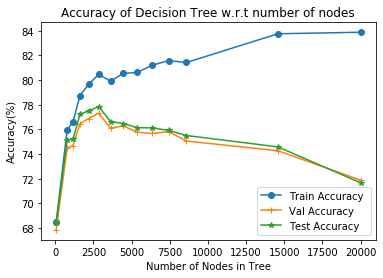

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(nodes, train_acc, marker='o', label='Train Accuracy ')
plt.plot(nodes, val_acc, marker='+', label='Val Accuracy')
plt.plot(nodes, test_acc, marker='*', label='Test Accuracy')
plt.xlabel("Number of Nodes in Tree")
plt.ylabel("Accuracy(%)")
plt.title("Accuracy of Decision Tree w.r.t number of nodes")
#plt.arrow(18000, 0.73, 15, 0.11, length_includes_head=True, head_width=0.001, head_length=0.0011)

#plt.plot(nodes, depth)
plt.legend()
#plt.savefig("plots/depth_accuracy_final.png", dpi=1000, bbox_inches='tight')
#plt.show()

In [78]:
prune = [19999, 17457, 15010, 12890, 11134, 9712, 8550, 7599, 6821, 6172, 5620, 5151, 4749, 4394, 4091, 3829, 3593, 3389]
train_prune = [83.87, 85.81, 85.51, 84.8, 83.97, 83.21, 82.59, 82.0, 81.5, 81.14, 80.72, 80.26, 79.9, 79.61, 79.33, 78.97, 78.67, 78.2]
val_prune = [71.88, 77.1, 77.6, 78.45, 78.71, 78.63, 78.73, 78.81, 79.04, 78.88, 78.67, 78.37, 78.2, 78.13, 78.01, 77.81, 77.52, 77.03]
test_prune =  [71.67, 77.45, 78.34, 79.07, 79.19, 79.22, 79.19, 79.26, 79.06, 78.97, 78.69, 78.39, 78.56, 78.48, 78.42, 78.19, 77.98, 77.67]

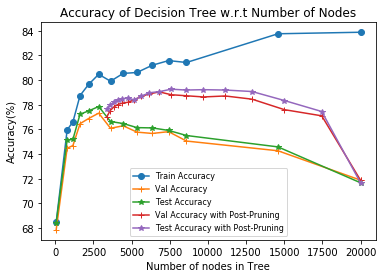

In [81]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(nodes, train_acc, marker='o', label='Train Accuracy ')
plt.plot(nodes, val_acc, marker='+', label='Val Accuracy')
plt.plot(nodes, test_acc, marker='*', label='Test Accuracy')

#plt.plot(prune, train_prune, marker='o', c='y', label='Train Accuracy ')
plt.plot(prune, val_prune, marker='+', label='Val Accuracy with Post-Pruning')
plt.plot(prune, test_prune, marker='*', label='Test Accuracy with Post-Pruning')
plt.xlabel("Number of nodes in Tree")
plt.ylabel("Accuracy(%)")
plt.title("Accuracy of Decision Tree w.r.t Number of Nodes")
#plt.arrow(18000, 0.73, 15, 0.11, length_includes_head=True, head_width=0.001, head_length=0.0011)

#plt.plot(prune, depth)
plt.legend(fontsize=8)
#plt.savefig("plots/depth_accuracy_withPrune.png", dpi=1000, bbox_inches='tight')
plt.show()